# Instalacja Bibliotek

In [ ]:
from landsatxplore.api import API
from landsatxplore.earthexplorer import EarthExplorer
import os

# Dane logowania do USGS
username = 'Morpheus1024'
password = 'Niy$@Km!j6W2K9mzo5x#U@^#UzDFY#Bxb@sX%5PZwL2Pzc@GE33YhH4$cP'

# Inicjalizacja API
api = API(username, password)

# Wyszukiwanie scen Landsat 8
scenes = api.search(
    dataset='landsat_8_c1',
    latitude=52.2297,
    longitude=21.0122,
    start_date='2021-01-01',
    end_date='2021-12-31',
    max_cloud_cover=10
)

# Wypisanie znalezionych scen
for scene in scenes:
    print(scene['entity_id'], scene['acquisition_date'])

# Zamknięcie połączenia API
api.logout()

# Inicjalizacja EarthExplorer
ee = EarthExplorer(username, password)

# Pobieranie pierwszej znalezionej sceny
output_dir = 'landsat_data'
os.makedirs(output_dir, exist_ok=True)

if scenes:
    scene_id = scenes[0]['entity_id']
    ee.download(scene_id, output_dir=output_dir)

# Zamknięcie połączenia EarthExplorer
ee.logout()

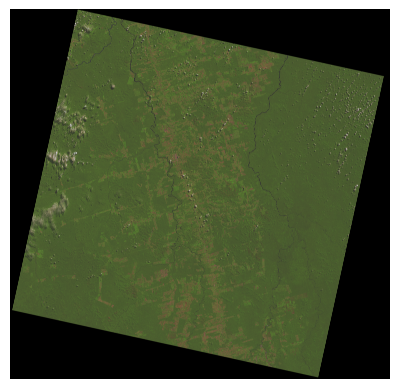

In [9]:
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt
#tif_image = Image.open('Landsat/2019/LE07_L2SP_191022_20190415_20200827_02_T1_SR_B5.TIF')
# Ścieżki do plików z kanałami
band5_path = 'Landsat/Las/2013/LC08_L2SP_227065_20130621_20200912_02_T1_SR_B6.TIF'  # Red
band4_path = 'Landsat/Las/2013/LC08_L2SP_227065_20130621_20200912_02_T1_SR_B5.TIF'  # Green
band3_path = 'Landsat/Las/2013/LC08_L2SP_227065_20130621_20200912_02_T1_SR_B4.TIF'  # Blue

# Otwórz kanały
band4 = tiff.imread(band5_path)
band3 = tiff.imread(band4_path)
band2 = tiff.imread(band3_path)

# Normalizacja kanałów (opcjonalnie, aby upewnić się, że wartości mieszczą się w zakresie 0-255)
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min) / (array_max - array_min) * 255).astype(np.uint8)

band4 = normalize(band4)
band3 = normalize(band3)
band2 = normalize(band2)

# Stwórz obraz RGB
rgb_image = np.dstack((band4, band3, band2))

# Wyświetl obraz
plt.imshow(rgb_image)
plt.imsave('2013.jpg', rgb_image)
#plt.imsave('2013.png', rgb_image)
plt.axis('off')  # Ukryj osie
plt.show()

In [ ]:
# segmentacja wcztanego zdjęcia landsat przy pimocy torchgeo
#halo?
from torch.utils.data import DataLoader
from torchgeo.datasets import CDL, Landsat7, Landsat8, stack_samples
from torchgeo.samplers import RandomGeoSampler

import torchvision.transforms as T



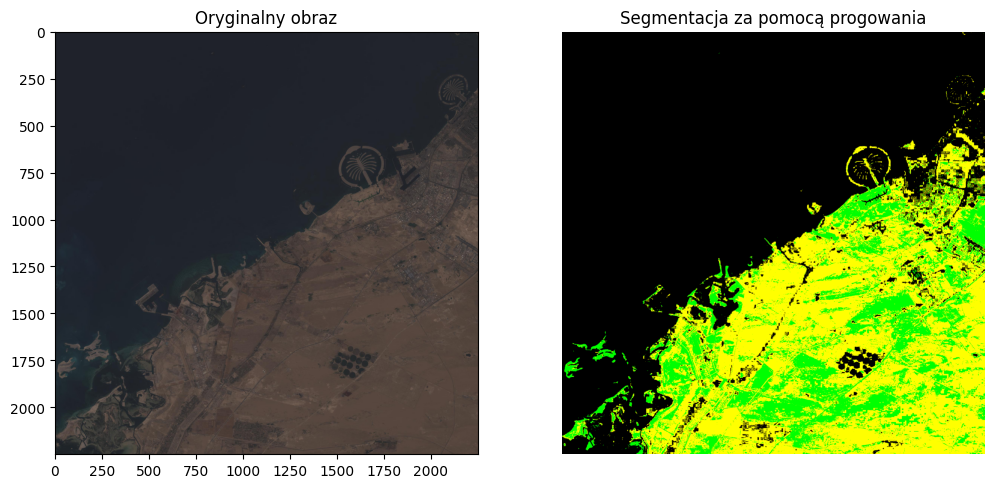

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Wczytaj obraz
img = cv2.imread('dubaj_2024_1.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)

# Definicja progów dla LAB (dostosuj wartości progów według własnych potrzeb)
thresholds = [
    (np.array([0, 0, 0]), np.array([80, 80, 80])),
    (np.array([80, 80, 80]), np.array([160, 160, 160])),
    (np.array([160, 160, 160]), np.array([240, 240, 240])),
    (np.array([20, 130, 130]), np.array([80, 150, 150])),
    (np.array([80, 150, 150]), np.array([140, 230, 230])),
]

# Tworzenie maski dla każdego progu
masks = [cv2.inRange(img_lab, lower, upper) for lower, upper in thresholds]

# Tworzenie segmentowanego obrazu
segmented_img = np.zeros_like(img_rgb)

# Kolory do wizualizacji segmentów
colors = [
    [255, 0, 0],  # czerwony
    [0, 255, 0],  # zielony
    [0, 0, 255],  # niebieski
    [255, 255, 0], # żółty
    [0, 255, 255]  # cyan
]

# Nałożenie masek na oryginalny obraz
for mask, color in zip(masks, colors):
    segmented_img[mask != 0] = color

# Wyświetl oryginalny obraz i wynik segmentacji
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Oryginalny obraz')
plt.imshow(img_rgb)
plt.subplot(1, 2, 2)
plt.title('Segmentacja za pomocą progowania')
plt.imshow(segmented_img)
plt.axis('off')
plt.show()

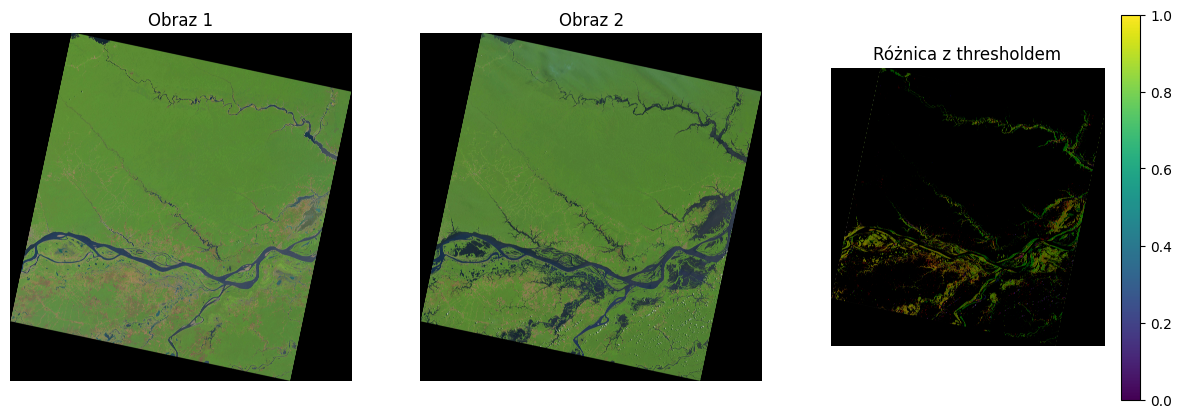

Klasyfikacja zmian: {'miasto': 4795012}


In [30]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Funkcja do klasyfikacji kolorów
def classify_color(color):
    # Definiowanie kolorów (woda, lasy, miasta)
    water_color = np.array([0, 0, 255])
    forest_color = np.array([0, 255, 0])
    city_color = np.array([128, 128, 128])

    # Obliczanie odległości euklidesowych
    dist_water = np.linalg.norm(color - water_color)
    dist_forest = np.linalg.norm(color - forest_color)
    dist_city = np.linalg.norm(color - city_color)

    # Klasyfikacja na podstawie najmniejszej odległości
    if dist_water < dist_forest and dist_water < dist_city:
        return 'woda'
    elif dist_forest < dist_water and dist_forest < dist_city:
        return 'las'
    else:
        return 'miasto'

# Wczytaj obrazy
image1 = Image.open('LC08_L1TP_230062_20231028_20231101_02_T1.jpg')
image2 = Image.open('LC08_L1TP_230062_20190830_20200826_02_T1.jpg')

# Konwertuj obrazy na tablice NumPy
image1_np = np.array(image1)
image2_np = np.array(image2)

# Znajdź minimalne wymiary wspólne dla obu obrazów
min_height = min(image1_np.shape[0], image2_np.shape[0])
min_width = min(image1_np.shape[1], image2_np.shape[1])

# Przytnij obrazy do minimalnych wymiarów
image1_np = image1_np[:min_height, :min_width]
image2_np = image2_np[:min_height, :min_width]

# Oblicz różnicę
difference = np.abs(image1_np.astype(int) - image2_np.astype(int))

# Normalizuj różnicę dla wyświetlenia
difference_normalized = (difference - difference.min()) / (difference.max() - difference.min())

# Zastosuj threshold
threshold = 0.25
difference_thresholded = np.where(difference_normalized > threshold, difference_normalized, 0)

# Wyświetl obrazy obok siebie
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Wyświetl pierwszy obraz
axs[0].imshow(image1)
axs[0].set_title('Obraz 1')
axs[0].axis('off')

# Wyświetl drugi obraz
axs[1].imshow(image2)
axs[1].set_title('Obraz 2')
axs[1].axis('off')

# Wyświetl różnicę z thresholdem
cax = axs[2].imshow(difference_thresholded)
axs[2].set_title('Różnica z thresholdem')
axs[2].axis('off')

# Dodaj colorbar do ostatniego obrazu
fig.colorbar(cax, ax=axs[2], orientation='vertical')

# Pokaż obrazy
plt.show()

# Klasyfikuj zmiany
classified_changes = np.full((min_height, min_width), '', dtype=object)

for i in range(min_height):
    for j in range(min_width):
        if difference_thresholded[i, j].any():
            classified_changes[i, j] = classify_color(image1_np[i, j])

# Wyświetl klasyfikację zmian
unique, counts = np.unique(classified_changes[classified_changes != ''], return_counts=True)
classification_results = dict(zip(unique, counts))
print("Klasyfikacja zmian:", classification_results)


In [ ]:

landsat_dataset_2000 = Landsat7('Landsat/2000/')
landsat_dataset_2010 = Landsat7('Landsat/2010') # Wyświetl kanały
landsat_dataset_2019 = Landsat7('Landsat/2019/')

#łaczenie w jeden dataset
dataset = landsat_dataset_2010 | landsat_dataset_2019 | landsat_dataset_2000

transform = T.Compose([
    T.ToTensor(),
     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)



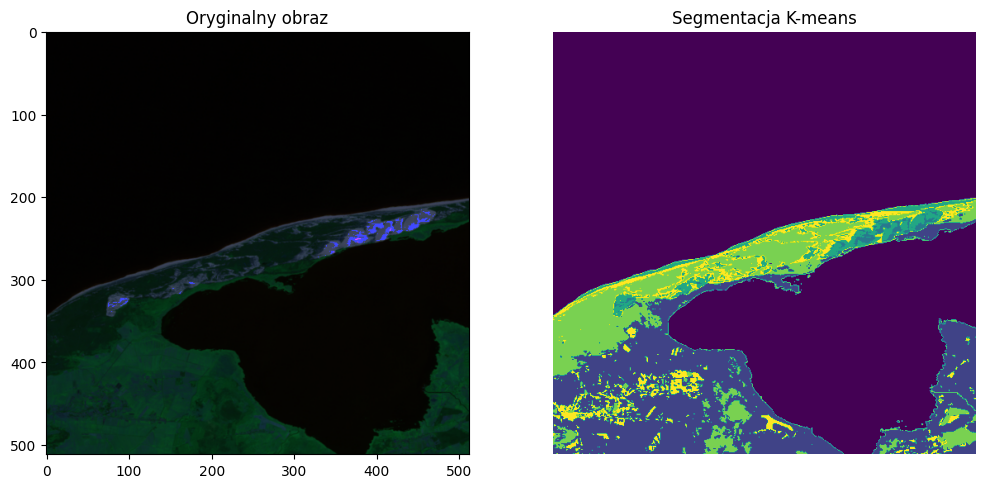

In [90]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

img = cv2.imread('Landsat/2000/sections/section_5_8.png')
img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_ = cv2.cvtColor(img_, cv2.COLOR_RGB2LAB)

pixels = img.reshape((-1, 3))

kmeans = KMeans(n_clusters=6, random_state=5000)
kmeans.fit(pixels)
labels = kmeans.labels_
segmented_img = labels.reshape(img.shape[:2])

# Wyświetl oryginalny obraz i wynik segmentacji
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Oryginalny obraz')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('Segmentacja K-means')
plt.imshow(segmented_img)#, cmap='gray')
plt.axis('off')
plt.show()

# Dodanie wytrenowanego modelu

https://pytorch.org/vision/stable/models.html

#### semantyczna

Landsat/2018/LE07_L2SP_190022_20180523_20200829_02_T1_SR_B3.TIF

In [ ]:
import os
import torch
from samgeo import SamGeo

# Ścieżka do własnego obrazu wejściowego
image = 'Landsat/2018/sections/section_8_8.png'

# Ścieżka do pliku wyjściowego dla segmentacji
mask = 'segment.tif'

# Ścieżka do pliku wyjściowego dla wektorowej maski segmentacji
vector = 'segment.gpkg'

# Ścieżka do pliku checkpoint modelu SAM
out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
checkpoint = os.path.join(out_dir, 'sam_vit_h_4b8939.pth')

# Wykrywanie urządzenia (GPU lub CPU)
device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'

# Inicjalizacja obiektu SamGeo z odpowiednimi parametrami
sam = SamGeo(
    checkpoint=checkpoint,
    model_type='vit_h',
    device=device,
    erosion_kernel=(3, 3),
    mask_multiplier=255,
    sam_kwargs=None,
)

# Generowanie maski segmentacji
sam.generate(image, mask)

# Konwersja maski segmentacji do formatu wektorowego
sam.tiff_to_gpkg(mask, vector, simplify_tolerance=None)

#### Dokonuje klasyfikacji, ale do dopracowania

In [ ]:

import torch
from PIL import Image
from torchvision import transforms, models
import matplotlib.pyplot as plt

#model = models.segmentation.deeplabv3_resnet101(pretrainemodel = models.segmentation.deeplabv3_mobilenet_v3_large(weights=models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)model = models.segmentation.deeplabv3_mobilenet_v3_large(weights=models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=True)ained=True)
model = models.segmentation.deeplabv3_mobilenet_v3_large(weights=models.segmentation.DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT)#deeplabv3
model.eval()

#img = Image.open('.jpg')
img = Image.open('Landsat/2019/sections/section_5_8.png')
#iimg = Image.open('Landsat/2018/stacked_landsat.tif')
img = img.convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize((520, 520)),  # Dopasowanie rozmiaru obrazu
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)['out'][0]
output_predictions = output.argmax(0)

print("Unique classes in output_predictions:", torch.unique(output_predictions))

LABEL_COLORS = np.array([
    [0, 0, 0],        # Background
    [128, 64, 128],   # Road
    [70, 70, 70],     # Building
    [107, 142, 35],   # Vegetation
    [152, 251, 152],  # Terrain
    [0, 130, 180],    # Water
    # Dodaj więcej klas w razie potrzeby
])

# Konwersja wyników na obraz
segmentation_map = LABEL_COLORS[output_predictions.cpu().numpy()]
segmentation_map = segmentation_map.astype(np.uint8)

import matplotlib.pyplot as plt
plt.imshow(segmentation_map)
plt.axis('off')
plt.show()



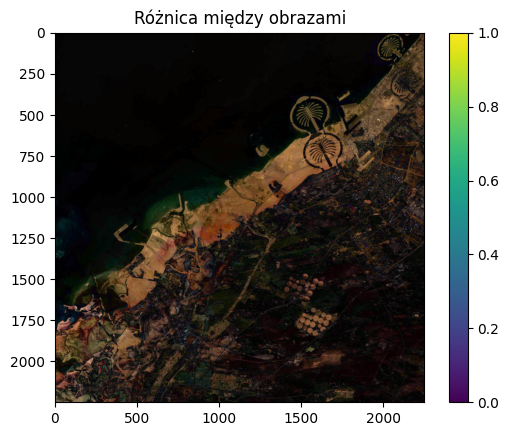

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Wczytaj obrazy
image1 = Image.open('dubaj_2013_1.jpg')
image2 = Image.open('dubaj_2024_1.jpg')

# Konwertuj obrazy na tablice NumPy
image1_np = np.array(image1)
image2_np = np.array(image2)

# Oblicz różnicę
difference = np.abs(image1_np.astype(int) - image2_np.astype(int))

# Normalizuj różnicę dla wyświetlenia
difference = (difference - difference.min()) / (difference.max() - difference.min())

# Pokaż różnicę
plt.imshow(difference)
plt.colorbar()
plt.title('Różnica między obrazami')
plt.show()

In [ ]:
!pip install torchgeo
!pip install torch
!pip install pillow
!pip install matplotlib
!pip install numpy
!pip install tifffile


# Importy

In [ ]:
# importy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import tifffile as tiff
import torchgeo


import cv2
import numpy as np
import matplotlib.pyplot as plt

# Wczytaj obraz
img = cv2.imread('Landsat/2000/sections/section_5_8.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)

# Definicja progów dla LAB (dostosuj wartości progów według własnych potrzeb)
thresholds = [
    (np.array([0, 0, 0]), np.array([80, 80, 80])),
    (np.array([80, 80, 80]), np.array([160, 160, 160])),
    (np.array([160, 160, 160]), np.array([240, 240, 240])),
    (np.array([20, 130, 130]), np.array([80, 150, 150])),
    (np.array([80, 150, 150]), np.array([140, 230, 230])),
]

# Tworzenie maski dla każdego progu
masks = [cv2.inRange(img_lab, lower, upper) for lower, upper in thresholds]

# Tworzenie segmentowanego obrazu
segmented_img = np.zeros_like(img_rgb)

# Kolory do wizualizacji segmentów
colors = [
    [255, 0, 0],  # czerwony
    [0, 255, 0],  # zielony
    [0, 0, 255],  # niebieski
    [255, 255, 0], # żółty
    [0, 255, 255]  # cyan
]

# Nałożenie masek na oryginalny obraz
for mask, color in zip(masks, colors):
    segmented_img[mask != 0] = color

# Wyświetl oryginalny obraz i wynik segmentacji
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Oryginalny obraz')
plt.imshow(img_rgb)
plt.subplot(1, 2, 2)
plt.title('Segmentacja za pomocą progowania')
plt.imshow(segmented_img)
plt.axis('off')
plt.show()# Wyświetlenie przykładowego zdjęcia

#### https://earthexplorer.usgs.gov/

In [ ]:
from PIL import Image
from ultralytics import YOLO
from ultralytics import SAM
import matplotlib.pyplot as plt

#model = YOLO('yolov8n-seg.pt')
#odel = YOLO('yolov8x-seg.pt')
#model = YOLO('yolov9e-seg.pt')
#model = YOLO('yolov9c-seg.pt')
#model = SAM('sam_b.pt')
img = Image.open('Landsat/2000/sections/section_1_3.png')

results = model(img)
annotated_img = results[0].plot()


plt.imshow(annotated_img)
plt.axis('off')
plt.show()



#### Notatki Oliwer